In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats
from scipy.io import wavfile
from scipy.spatial.distance import cdist
from scipy.fftpack import fft

Task
i. Read the training data, which is in the form of music file. Convert them into spectrogram with window 25 ms and shift of 10 ms with 64 component FFT
Similarly do for test files

ii. From spectrogram of music and speech file, we will cluster the data in 8 clusters. We will fit two KMeans model on the data. Cluster assignment is treated as observation symbol corresponding to Each dataframe. 

a. We will find the likelihood of obsevation for each file with the help of Forward algorithm. Find the the music file which corresponds to maximum likelihood. 

b. Similarly we can find likelihood for each state with the help of the backward algorithm

c. Implementation of Viterbi algorithm to predict most probable sequence of states

c. Implementation of Baum-Welch reestimation to learn the parameter of the model

d. Test the model with the help of the testing data
    First convert the spectrogram into observation states using KMeans model. We will get two sets of observation states from two different KMeans models
    Pass that observation set corresponding to Music HMM model and Speech HMM model to calculate the likelihood 
    This will calculate the likelihood (Use of forward)
    Class is decided by Maximum likelihood among both 
    Calculate the accuracy
    

In [2]:
def displayPlot(x,y,lab,loca,xlab,ylab,title):
    plt.figure
    plt.plot(x,y,label=lab)    
    plt.legend(loc=loca)
    plt.xlabel(xlab,size=12)
    plt.ylabel(ylab,size=12)
    plt.title(title,size=15)
    plt.savefig(lab+'.png')
    plt.show()

In [3]:
def spectrogram(fileName, window, shift,fft_points,frames):
    sample_rate, data = wavfile.read(fileName)
    sg = []
    window = int(sample_rate*window/1000)
    shift = int(sample_rate*shift/1000)
    half_fft = int(fft_points/2) 
    hammW = np.hamming(window)
    for i in range(frames):
        data_window = data[i*shift:i*shift+window]
        #data_fft =  np.log(np.abs(fft(data_window,fft_points)))        # for  Without hamming function 
        data_fft =  np.log(np.abs(fft(data_window*hammW,fft_points)))   # for  With hamming function 
        sg.append(data_fft[:half_fft])
    sg = (np.array(sg)).T    
    return  sample_rate,  data, sg

In [4]:
# o is the observation sequence
# o --> No of Time steps * 1
# a --> No of states * No of states
# b --> No of states * No of observation Symbols
# pi --> No of states * 1

def forward(o,a,b,pi):
    T = o.shape[0]
    N = a.shape[0]
    sum_t = []
    # print(T,N)
    # Initialise alpha
    alpha = np.zeros((N,T))
    for i in range(N):
        alpha[i][0]=pi[i]*b[i][o[0]]
    sc = (np.sum(alpha[:,0])) 
    #
    alpha[:,0] = alpha[:,0]/sc
    sum_t.append(1/sc)
    #print(alpha[:,0])
    
    for t in range(T-1):
        for j in range(N):    # for alpha[j][]
            temp = 0
            for i in range(N):
                temp += alpha[i][t]*a[i][j]
            alpha[j][t+1] = temp*b[j][o[t+1]]
        sc = (np.sum(alpha[:,t+1])) 
        sum_t.append(1.0/sc)
        alpha[:,t+1] = alpha[:,t+1]/sc
    # termination
    alpha_T_sum = np.sum(alpha[:,T-1])
    lk = (np.sum(np.log(sum_t)))*-1.0
    return alpha, alpha_T_sum, lk 

In [5]:
# o is the observation sequence
# o --> No of Time steps * 1
# a --> No of states * No of states
# b --> No of states * No of observation Symbols
# pi --> No of states * 1

def backward(o,a,b,pi):
    T = o.shape[0]
    N = a.shape[0]
    sum_t = []
    # Initialise beta
    beta = np.zeros((N,T))
    for i in range(N):
        beta[i][T-1]=1
    t = T-2
    while(t>=0):
        for i in range(N):    # for beta[i][]
            temp = 0
            for j in range(N):
                temp += a[i][j]*beta[j][t+1]*b[j][o[t+1]]
            beta[i][t] = temp
        sc = (np.sum(beta[:,t]))
        sum_t.append(1.0/sc)
        beta[:,t] = beta[:,t]/sc
            #print(o[t+1],beta[i][t])
        # Termination
        
        t -=1
    lk = (np.sum(np.log(sum_t)))*-1.0
    return beta, lk

In [6]:
# o is the observation sequence
# o --> No of Time steps * 1
# a --> No of states * No of states
# b --> No of states * No of observation Symbols
# pi --> No of states * 1

def Viterbi(o,a,b,pi):
    T = o.shape[0]
    N = a.shape[0]
    delta = np.zeros((N,T))
    si = np.zeros((N,T))
    q = np.zeros(T)
    #print("Number of time steps:",T)
    #print("Number of states:",N)
    #print("Model parameters :\n",'a:\n',a,'\nb:\n',b,'\n pi:\n',pi)
    # Initialization
    for i in range(N):
        delta[i][0] = pi[i]*b[i][o[0]]
        
    # Normalise 
    sc = (np.sum(delta[:,0])) 
    delta[:,0] = delta[:,0]/sc
    
    # Recursion
    for t in range(T-1):
        for j in range(N):
            maximum = 0
            maxindex = 0
            for i in range(N):
                if maximum < delta[i][t]*a[i][j]:
                    maximum = delta[i][t]*a[i][j]
                    maxindex = i
            
            delta[j][t+1] = maximum*b[j][o[t+1]]
            si[j][t+1] = maxindex
        # Normalise 
        sc = (np.sum(delta[:,t+1])) 
        delta[:,t+1] = delta[:,t+1]/sc
    
    # Terminate
    pstar = np.max(delta[:,T-1])
    q[T-1] = (np.where(delta[:,T-1] == np.amax(delta[:,T-1]))[0][0])
    q[T-1] = int(q[T-1])
    t = T-2
    while t>=0:
        q[t] = si[int(q[t+1])][t+1]
        t -= 1
    print(q)
    return q
            
    

In [7]:
# o is the observation sequence
# o -->  No of Files * No of Time steps 
# a --> No of states * No of states
# b --> No of states * No of observation Symbols
# pi --> No of states * 1


def BaumWelch(o,a,b,pi, no_iter):
    T = o.shape[1]     # No of Time steps
    N = a.shape[0]     # No of states
    S = b.shape[1]     # No of observation Symbols
    No_files = o.shape[0]
    
    print("Number of time steps:",T)
    print("Number of states:",N)
    print("Number of observation states:",S)
    print("Number of files: ", No_files)
    print("Initial Guess :\n",'a:\n',a,'\nb:\n',b,'\n pi:\n',pi)
    alpha = np.zeros((No_files,N,T))
    beta = np.zeros((No_files,N,T))
    xi = np.zeros((No_files,T-1,N,N))
    gamma = np.zeros((No_files, N, T))
    pk = np.zeros(No_files)
    
    a_new = np.zeros((N,N))
    b_new = np.zeros((N,S))
    pi_new = np.zeros(N)
    likelihood_it = []
    for n in range(no_iter):
        print("iteration number:", n)
        likelihood_iteration = 0.0
        for k in range(No_files): 
            
            # *************************** Step 1 of algorithm ********************************* 
            
            # Calculation of alpha, beta, gamma, xi
            p,q,r = forward(o[k,:],a,b,pi)
            alpha[k] = p
            likelihood_iteration += r
            e,f = backward(o[k,:],a,b,pi)
            beta[k] = e
            #print(alpha[k])
            #print(beta[k])
            # Loop for calculation of xi
            for t in range(T-1):
                deno = 0.0
                for i in range(N):
                    for j in range(N):
                        deno += alpha[k][i][t]*a[i][j]*b[j][o[k][t+1]]*beta[k][j][t+1]

                for i in range(N):
                    for j in range(N):
                        xi[k][t][i][j] = (alpha[k][i][t]*a[i][j]*b[j][o[k][t+1]]*beta[k][j][t+1])/deno

            # Loop for calculation of gamma
            for t in range(T):
                deno = 0.0
                for j in range(N):
                    deno += alpha[k][j][t]*beta[k][j][t]

                for i in range(N):
                    gamma[k][i][t] = (alpha[k][i][t]*beta[k][i][t])/deno
                    
            for i in range(N):
                pk[k] += alpha[k][i][T-1]

                
        # *********************** Step 2 of Algorithm ***************************************
        
        # Reestimating a,b,pi
        
        # pi
        for i in range(N):
            temp_pi_sum = 0.0
            for k in range(No_files):
                temp_pi_sum += gamma[k,i,0]
            pi_new[i] = temp_pi_sum/No_files
            
        # a
        for i in range(N):
            for j in range(N):
                num_a = 0.0
                deno_a = 0.0
                for k in range(No_files):
                    for t in range(T-1):
                        num_a += xi[k,t,i,j]
                        deno_a += gamma[k,i,t]
                a_new[i][j] = num_a/deno_a
                
        # b
        for i in range(N):        
            for j in range(S):
                deno_b=0.0
                num_b =0.0
                for k in range(No_files):
                    for t in range(T-1):
                        deno_b += gamma[k,i,t]
                        if(o[k][t] == j):
                            num_b += gamma[k,i,t]           
                b_new[i][j] = num_b/deno_b
                
        # Updating a,b,pi
        pi = pi_new
        a =a_new
        b = b_new
        print("Likelihood of the iteration is ",likelihood_iteration)
        likelihood_it.append(likelihood_iteration)
                
    return a,b,pi, likelihood_it                    


#                            Main program 

Generate spectrogram features - Use the log magnitude spectrogram as before with
a 64 component magnitude FFT (NFFT). In this case, the spectrogram will have
dimension 32 times the number of frames (using 25 ms with a shift of 10 ms).

In [8]:
#  i. Read the training data, which is in the form of music file. 
# Convert them into spectrogram with window 25 ms and shift of 10 ms with 64 component FFT Similarly do for test file

# Initial inputs 
# Training data
path_music = './speech_music_classification/train/music'
path_speech = './speech_music_classification/train/speech'
files_music = os.listdir(path_music)
files_speech = os.listdir(path_speech)

a_ = 32
b_ = 2998
total_samples = len(files_music)
total_sequences = total_samples
# Number of frames * Number of features 
music = np.zeros((b_ * total_samples, a_))
speech = np.zeros((b_ * total_samples, a_))

In [9]:
windowSz = 25
shift = 10
fft_points = 64
# Music data
for i in range(total_samples):
    freq, signal, spec = spectrogram(path_music + '/' + files_music[i], windowSz, shift,fft_points,b_)
    spec = spec.T
    music[b_ * i: b_ * (i+1), :] = spec

# Speech data
for i in range(total_samples):
    freq, signal, spec = spectrogram(path_speech + '/' + files_speech[i], windowSz, shift,fft_points,b_)
    spec = spec.T
    speech[b_ * i:b_ * (i+1), :] = spec

Perform a K-means clustering on the spectrogram with K = 8 (using both speech
and music data) and cluster the spectrogram features into discrete symbols

In [10]:
# From spsectrogram of music and speech file, we will cluster the data in 8 clusters. 
# we will fit two KMeans model on the data. 
# Cluster assignment is treated as observation symbol corresponding to Each dataframe

# KMeans model for Music
from sklearn.cluster import KMeans
kmeans_music = KMeans(n_clusters = 8, init = 'k-means++', random_state = 63)
y_kmeans_music = kmeans_music.fit_predict(music)

# KMeans model for Speech
from sklearn.cluster import KMeans
kmeans_speech = KMeans(n_clusters = 8, init = 'k-means++', random_state = 63)
y_kmeans_speech = kmeans_speech.fit_predict(speech)

In [11]:
#total_data = music+speech
total_data = np.array(music.copy())
speech_np = np.array(speech.copy())
total_data = np.concatenate((total_data, speech_np), axis=0)

In [12]:
total_data.shape

(239840, 32)

In [13]:
# KMeans model for total
from sklearn.cluster import KMeans
kmeans_t = KMeans(n_clusters = 8, init = 'k-means++', random_state = 63)
y_kmeans_t = kmeans_t.fit_predict(total_data)

In [14]:
y_kmeans_t.shape

(239840,)

In [15]:
# Reshaping the observation sequences 
o_t =  y_kmeans_t.reshape(total_sequences*2, b_) 

In [16]:
print(o_t.shape)

(80, 2998)


In [17]:
o_music = o_t[0:total_samples,:]
o_speech = o_t[total_samples:,:]

In [18]:
print(o_music.shape)
print(o_speech.shape)

(40, 2998)
(40, 2998)


In [19]:
# Initial Model 
# Transition Probabilities
#3*3
a = np.array([[0.6, 0.4, 0.0],
    [0.3, 0.5, 0.2],
    [0.0, 0.1, 0.9]])
 
# Emission Probabilities
# 3*8
b = np.array([[0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, 0.0],
    [0.125, 0.125,0.125,0.125,0.125,0.125,0.125,0.125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.5,0.5,0.0]])

# Equal Probabilities for the initial distribution
# 3*1
pi = np.array((0.5, 0.5, 0.0))

#                         FORWARD PROCEDURE

In [20]:
# Music files forward 
alpha_music = []
alpha_sum_music = []
likelihood_music_forward = []
for i in range(total_samples):
    alpha, alpha_sum, lk = forward(o_music[i,:], a, b, pi)
    alpha_music.append(alpha)
    alpha_sum_music.append(alpha_sum)
    likelihood_music_forward.append(lk)
    


In [21]:
(likelihood_music_forward)

[-5405.557164434227,
 -6130.00475426054,
 -6587.962874987519,
 -6165.779129656952,
 -5969.483444660626,
 -6592.910815360441,
 -5586.927690217386,
 -5884.822026648786,
 -5863.536610429444,
 -6276.464149793054,
 -5589.101879765597,
 -6425.328870285989,
 -5463.8960603097385,
 -6090.524266946226,
 -6094.180385786557,
 -6277.298193451981,
 -6383.125398486329,
 -6187.490695920059,
 -6165.898215726258,
 -5842.664932826025,
 -6538.295084764308,
 -6201.8928843222375,
 -5907.183731080832,
 -6111.471685277618,
 -6444.429862525061,
 -6608.607625649129,
 -5362.449629683476,
 -6097.264622088631,
 -5536.2155039366235,
 -6619.1635555296525,
 -5996.269570924511,
 -5898.651727782132,
 -5192.867539522451,
 -6132.480500563514,
 -5900.885740494553,
 -6467.5121938561415,
 -6645.407275193028,
 -5883.06865211892,
 -5196.893749922714,
 -6856.777605023985]

In [22]:
# Speech files forward
alpha_speech = []
alpha_sum_speech = []
likelihood_speech_forward = []
for i in range(total_samples):
    alpha, alpha_sum, lk = forward(o_speech[i,:], a, b, pi)
    alpha_speech.append(alpha)
    alpha_sum_speech.append(alpha_sum)
    likelihood_speech_forward.append(lk)

In [23]:
(likelihood_speech_forward)

[-6215.2689526704635,
 -5863.072228796822,
 -6390.603295569374,
 -5813.373159899628,
 -5972.434570198586,
 -5961.9518305703805,
 -6135.327690558904,
 -6229.489446645975,
 -5755.713513516226,
 -6449.578213297291,
 -6124.025858207948,
 -5575.408696473907,
 -6072.698427889216,
 -6330.675089327305,
 -6087.95959301316,
 -6412.500986242542,
 -5854.290267049231,
 -5996.444002638049,
 -5800.649695689905,
 -5358.021138655458,
 -6307.469288569455,
 -5543.849189672581,
 -6210.121864173298,
 -5299.262166848401,
 -6100.730672946127,
 -6151.284634502484,
 -6223.293863904541,
 -6016.048639485907,
 -6147.421934623611,
 -5796.324709606065,
 -6619.416770614802,
 -6285.693148967108,
 -5997.511772103062,
 -6245.083558658692,
 -6010.625454891529,
 -6215.206269836009,
 -5627.8161291686865,
 -6255.503562526521,
 -6196.898569773913,
 -6510.692859272903]

#                            BACKWARD PROCEDURE

In [24]:
# Music files backward
beta_music = []
likelihood_music_backward = []
for i in range(total_samples):
    beta, lk = backward(o_music[i,:], a, b, pi)
    beta_music.append(beta)
    likelihood_music_backward.append(lk)

In [25]:
likelihood_music_backward

[-5403.236658888253,
 -6127.67028532652,
 -6583.584462660721,
 -6162.0754095390475,
 -5967.120383998148,
 -6590.554561418547,
 -5584.607184671417,
 -5882.501521102816,
 -5859.151657016941,
 -6272.278398108614,
 -5586.781374219627,
 -6423.000924427179,
 -5461.575554763767,
 -6088.203760190041,
 -6091.845980335544,
 -6273.7519431446035,
 -6379.378488196459,
 -6184.980471462287,
 -6163.499442200282,
 -5839.931534693584,
 -6534.829348861507,
 -6197.655051342179,
 -5904.85864607604,
 -6107.803102629402,
 -6440.964126622262,
 -6606.287120103158,
 -5358.657980829929,
 -6093.623834838438,
 -5533.465116843547,
 -6616.65333107188,
 -5993.536070120263,
 -5896.331040356296,
 -5190.5470339764815,
 -6130.151605063071,
 -5898.5641702489775,
 -6463.827404387279,
 -6641.941539290228,
 -5880.695714534922,
 -5194.573244376743,
 -6854.2673805662125]

In [26]:
# Speech files backward
beta_speech = []
likelihood_speech_backward = []
for i in range(total_samples):
    beta, lk = backward(o_speech[i,:], a, b, pi)
    beta_speech.append(beta)
    likelihood_speech_backward.append(lk)

In [27]:
likelihood_speech_backward

[-6211.760358367729,
 -5860.750370038424,
 -6386.854143949442,
 -5810.965309809591,
 -5968.925844344629,
 -5959.6268094401685,
 -6131.642901090042,
 -6227.168941100004,
 -5752.7343626002985,
 -6445.84061660517,
 -6120.2765739057395,
 -5572.555541894623,
 -6070.377852571253,
 -6326.580082178309,
 -6085.603339071265,
 -6410.180480664346,
 -5850.664367461903,
 -5993.604336938279,
 -5798.202875143198,
 -5355.700633109489,
 -6305.113034627559,
 -5539.739627670417,
 -6206.372638784615,
 -5296.94166130243,
 -6097.264937043327,
 -6148.451720441845,
 -6220.783639446769,
 -6013.728132789294,
 -6145.10142907764,
 -5792.575425303858,
 -6617.09604762089,
 -6283.330706906121,
 -5995.191266557092,
 -6240.999851202455,
 -6008.304949345559,
 -6212.884699590434,
 -5625.082713508535,
 -6253.183056980551,
 -6194.568868289538,
 -6506.310358200647]

#                            Viterbi algorithm

In [28]:
# Music File
q_music = []
for i in range(total_samples):    # total_samples
    q = Viterbi(o_music[i,:], a, b, pi)
    q_music.append(np.array(q))
q_music = np.array(q_music)

[0. 0. 0. ... 2. 2. 2.]
[0. 0. 0. ... 0. 0. 1.]
[1. 2. 2. ... 1. 1. 0.]
[1. 1. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 1. 0.]
[0. 0. 1. ... 1. 1. 1.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 2. 2. ... 1. 1. 0.]
[1. 2. 2. ... 1. 0. 0.]
[0. 0. 0. ... 1. 1. 0.]
[0. 0. 0. ... 1. 1. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 2. 2.]
[0. 0. 0. ... 1. 1. 1.]
[1. 1. 2. ... 1. 1. 1.]
[1. 0. 0. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 1. 2. ... 1. 1. 0.]
[1. 2. 2. ... 0. 0. 0.]
[0. 0. 0. ... 2. 1. 0.]
[1. 1. 1. ... 0. 0. 1.]
[1. 1. 1. ... 0. 1. 0.]
[0. 0. 0. ... 1. 0. 0.]
[1. 1. 1. ... 2. 2. 2.]
[1. 1. 0. ... 1. 1. 0.]
[0. 1. 0. ... 0. 1. 0.]
[0. 1. 1. ... 0. 1. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 0.]
[0. 0. 0. ... 1. 2. 2.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[0. 0. 1. ... 2. 2. 1.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 1. 1. 1.]


In [29]:
print("Best state sequence for music files\n",q_music)

Best state sequence for music files
 [[0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 2. 2. ... 1. 1. 0.]
 ...
 [0. 0. 1. ... 2. 2. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 1. 1.]]


In [30]:
# Speech File
q_speech = []
for i in range(total_samples):    # total_samples
    q = Viterbi(o_speech[i,:], a, b, pi)
    q_speech.append(np.array(q))
q_speech = np.array(q_speech)

[0. 1. 1. ... 0. 0. 1.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 1. 1. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 1. 1.]
[1. 1. 1. ... 1. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 1. ... 1. 0. 0.]
[1. 0. 0. ... 1. 1. 1.]
[1. 0. 0. ... 1. 1. 2.]
[0. 1. 1. ... 1. 0. 0.]
[0. 0. 0. ... 1. 1. 2.]
[1. 1. 1. ... 1. 1. 0.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 0. ... 0. 0. 1.]
[1. 1. 0. ... 0. 0. 1.]
[0. 1. 1. ... 1. 1. 1.]
[0. 1. 2. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 2. 2. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 0.]
[1. 1. 1. ... 1. 2. 2.]
[0. 1. 1. ... 1. 2. 2.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 2.]
[0. 0. 1. ... 1. 1. 1.]
[0. 0. 0. ... 0. 0. 0.]
[1. 2. 2. ... 1. 0. 0.]
[0. 0. 0. ... 1. 1. 2.]
[0. 0. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 1. 1. 0.]
[0. 0. 0. ... 1. 1. 0.]
[1. 2. 2. ... 1. 1. 1.]


In [31]:
print("Best state sequence for music files\n",q_speech)

Best state sequence for music files
 [[0. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [1. 2. 2. ... 1. 1. 1.]]


#                                Baum Welch 

In [32]:
iteration_for_learning = 15

In [33]:
# Music HMM model learning
a_music,b_music,pi_music, lk_BW_music = BaumWelch(o_music,a,b,pi,iteration_for_learning)

Number of time steps: 2998
Number of states: 3
Number of observation states: 8
Number of files:  40
Initial Guess :
 a:
 [[0.6 0.4 0. ]
 [0.3 0.5 0.2]
 [0.  0.1 0.9]] 
b:
 [[0.25  0.25  0.25  0.25  0.    0.    0.    0.   ]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.    0.    0.    0.    0.    0.5   0.5   0.   ]] 
 pi:
 [0.5 0.5 0. ]
iteration number: 0
Likelihood of the iteration is  -242580.74630021324
iteration number: 1
Likelihood of the iteration is  -206230.28845286826
iteration number: 2
Likelihood of the iteration is  -203379.77812234382
iteration number: 3
Likelihood of the iteration is  -200121.14520318276
iteration number: 4
Likelihood of the iteration is  -196588.5643631441
iteration number: 5
Likelihood of the iteration is  -192639.04036673208
iteration number: 6
Likelihood of the iteration is  -188514.16331002212
iteration number: 7
Likelihood of the iteration is  -185491.90083378894
iteration number: 8
Likelihood of the iteration is  -184966.5866413604
iterati

In [34]:
print("Music Model parameters:")
print("a_music:\n\n",a_music,"\n \n b_music: \n ",b_music,"\n \n pi_music: \n",pi_music)

Music Model parameters:
a_music:

 [[0.91021937 0.08978063 0.        ]
 [0.04068567 0.89188072 0.06743361]
 [0.         0.43806811 0.56193189]] 
 
 b_music: 
  [[4.56096873e-09 4.61090661e-01 3.50553327e-06 5.38905829e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.04307784e-01 2.22056377e-01 2.45683924e-01 1.69519708e-02
  1.05205720e-02 2.37878580e-02 2.02572696e-01 1.74118817e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.52767860e-06 9.99995472e-01 0.00000000e+00]] 
 
 pi_music: 
 [0.19159019 0.80840981 0.        ]


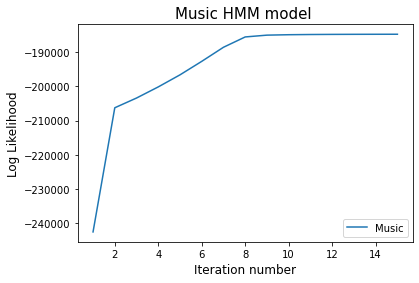

In [35]:
iteration_array = np.arange(1,iteration_for_learning+1)
displayPlot(iteration_array,lk_BW_music,"Music","lower right","Iteration number","Log Likelihood","Music HMM model ")

In [36]:
# Speech HMM model Learning 
a_speech,b_speech,pi_speech, lk_BW_speech = BaumWelch(o_speech,a,b,pi,iteration_for_learning)

Number of time steps: 2998
Number of states: 3
Number of observation states: 8
Number of files:  40
Initial Guess :
 a:
 [[0.6 0.4 0. ]
 [0.3 0.5 0.2]
 [0.  0.1 0.9]] 
b:
 [[0.25  0.25  0.25  0.25  0.    0.    0.    0.   ]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.    0.    0.    0.    0.    0.5   0.5   0.   ]] 
 pi:
 [0.5 0.5 0. ]
iteration number: 0
Likelihood of the iteration is  -242159.74171705608
iteration number: 1
Likelihood of the iteration is  -221372.63102591614
iteration number: 2
Likelihood of the iteration is  -218250.30691282928
iteration number: 3
Likelihood of the iteration is  -214375.1334775851
iteration number: 4
Likelihood of the iteration is  -209936.98045693876
iteration number: 5
Likelihood of the iteration is  -205735.13924874237
iteration number: 6
Likelihood of the iteration is  -202669.9237686437
iteration number: 7
Likelihood of the iteration is  -200043.95392028877
iteration number: 8
Likelihood of the iteration is  -197020.02300278653
iterati

In [62]:
print("Speech Model parameters:")
print("a_speech:\n\n",a_speech,"\n \n b_speech: \n ",b_speech,"\n \n pi_speech: \n",pi_speech)

Speech Model parameters:
a_speech:

 [[0.89452767 0.10547233 0.        ]
 [0.05225369 0.94059357 0.00715275]
 [0.         0.14227689 0.85772311]] 
 
 b_speech: 
  [[7.61745680e-01 5.17728414e-09 2.38254315e-01 8.52134755e-13
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.01741614e-02 2.12235840e-01 1.81943658e-01 1.03456435e-01
  1.01175160e-01 3.13126087e-02 2.20909840e-01 1.08792297e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 1.42294885e-11 0.00000000e+00]] 
 
 pi_speech: 
 [0.15549952 0.84450048 0.        ]


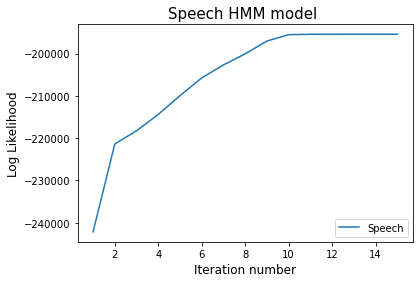

In [63]:
displayPlot(iteration_array,lk_BW_speech,"Speech","lower right","Iteration number","Log Likelihood","Speech HMM model ")

In [64]:
# Training accuracy

# Finding Likelihood of the observation from forward method Music model
alpha_train_music = []
alpha_sum_train_music = []
likelihood_train_music_forward = []
for i in range(total_samples):
    alpha, alpha_sum, lk = forward(o_music[i,:], a_music,b_music,pi_music)
    alpha_train_music.append(alpha)
    alpha_sum_train_music.append(alpha_sum)
    likelihood_train_music_forward.append(lk)


# Finding Likelihood of the observation from forward method speech model

alpha_train_speech = []
alpha_sum_train_speech = []
likelihood_train_speech_forward = []
for i in range(total_samples):
    alpha, alpha_sum, lk = forward(o_music[i,:],a_speech,b_speech,pi_speech)
    alpha_train_speech.append(alpha)
    alpha_sum_train_speech.append(alpha_sum)
    likelihood_train_speech_forward.append(lk)
    


In [65]:
# Predicting class
class_predict_train_music = []
for i in range(total_samples):
    if likelihood_train_music_forward[i]>likelihood_train_speech_forward[i]:
        class_predict_train_music.append(0)
    else:
        class_predict_train_music.append(1)

In [66]:
e_music = np.sum(np.array(class_predict_train_music))

In [67]:
# Training accuracy

# Finding Likelihood of the observation from forward method Music model
alpha_train_music = []
alpha_sum_train_music = []
likelihood_train_music_forward = []
for i in range(total_samples):
    alpha, alpha_sum, lk = forward(o_speech[i,:], a_music,b_music,pi_music)
    alpha_train_music.append(alpha)
    alpha_sum_train_music.append(alpha_sum)
    likelihood_train_music_forward.append(lk)


# Finding Likelihood of the observation from forward method speech model

alpha_train_speech = []
alpha_sum_train_speech = []
likelihood_train_speech_forward = []
for i in range(total_samples):
    alpha, alpha_sum, lk = forward(o_speech[i,:],a_speech,b_speech,pi_speech)
    alpha_train_speech.append(alpha)
    alpha_sum_train_speech.append(alpha_sum)
    likelihood_train_speech_forward.append(lk)

In [68]:
# Predicting class
class_predict_train_speech = []
for i in range(total_samples):
    if likelihood_train_music_forward[i]>likelihood_train_speech_forward[i]:
        class_predict_train_speech.append(0)
    else:
        class_predict_train_speech.append(1)

In [69]:
e_speech = total_samples- np.sum(np.array(class_predict_train_speech))

In [70]:
# Training error
print("Training error is ",100-(e_speech+e_music)*100/(2*total_samples))

Training error is  88.75


#                                Testing 

In [71]:
# Test File
#  i. Read the test data. 
# Convert them into spectrogram with window 25 ms and shift of 10 ms with 64 component FFT Similarly do for test file

# Initial inputs 
# test data
path_test = './speech_music_classification/test'
files_test = os.listdir(path_test)

a_ = 32
b_ = 2998
total_test_files = len(files_test)
total_test_sequences = total_test_files
# Number of frames * Number of features 
test = np.zeros((b_ * total_test_files, a_))


In [72]:
print("Number of test samples", total_test_files)

Number of test samples 48


In [73]:
windowSz = 25
shift = 10
fft_points = 64
# test data
for i in range(total_test_files):
    freq, signal, spec = spectrogram(path_test + '/' + files_test[i], windowSz, shift,fft_points,b_)
    spec = spec.T
    test[b_ * i: b_ * (i+1), :] = spec

In [74]:
# Observation sequence for test data from kmeans_music model
y_kmeans_test_t = kmeans_t.predict(test)
o_test_t =  y_kmeans_test_t.reshape(total_test_sequences, b_) 

In [105]:
print("Observation sequence of the Test data from Kmeans model for Speech\n",o_test_t)

Observation sequence of the Test data from Kmeans model for Speech
 [[7 1 7 ... 3 7 1]
 [3 3 3 ... 3 3 1]
 [1 1 1 ... 3 3 3]
 ...
 [1 1 7 ... 1 1 1]
 [7 7 1 ... 3 7 7]
 [3 1 6 ... 0 0 0]]


In [76]:
# Observation sequence for test data from kmeans_speech model
y_kmeans_test_speech = kmeans_speech.predict(test)
o_test_speech =  y_kmeans_test_speech.reshape(total_test_sequences, b_) 

In [77]:
print("Observation sequence of the Test data from Kmeans model for Speech",o_test_speech)

Observation sequence of the Test data from Kmeans model for Speech [[1 1 5 ... 7 5 1]
 [7 7 7 ... 7 7 1]
 [7 1 1 ... 7 7 7]
 ...
 [1 1 5 ... 1 7 1]
 [5 5 1 ... 7 5 5]
 [7 1 5 ... 2 2 2]]


In [78]:
# Finding Likelihood of the observation from forward method Music model
alpha_test_music = []
alpha_sum_test_music = []
likelihood_test_music_forward = []
for i in range(total_test_files):
    alpha, alpha_sum, lk = forward(o_test_t[i,:], a_music,b_music,pi_music)
    alpha_test_music.append(alpha)
    alpha_sum_test_music.append(alpha_sum)
    likelihood_test_music_forward.append(lk)
    


In [79]:
print("Likelihood of the test For Music HMM model",likelihood_test_music_forward)

Likelihood of the test For Music HMM model [-5016.2618813747495, -3568.6338868860257, -3344.321301294068, -4992.385770342187, -5003.423119865537, -4694.6931794878, -3583.2813882485643, -3888.1423592999477, -4311.086419092286, -4371.8192549477135, -4644.2655061693185, -4032.237210698372, -3858.9786651091185, -4093.5217053145134, -4650.094110379309, -4916.427814884378, -4384.3695380747895, -5340.086531776136, -4720.13091914172, -3981.2045443770257, -3721.133985789388, -4548.962080652277, -5572.69141441139, -4501.463926735141, -7407.936726374175, -6424.352419394384, -7268.757065700087, -5899.463079252176, -5713.535185682521, -6356.986656646128, -6125.791865531082, -5654.297184867384, -4676.718798713304, -5955.048850021592, -6564.146815889022, -5279.9169255479355, -5341.0479336302815, -5893.536729322779, -6034.28939032613, -5946.02670645382, -6534.918433323559, -7011.6429236721815, -5671.711613932425, -5058.800101450584, -5041.992033724808, -5233.966426587067, -5742.959267001015, -5981.778

In [80]:
# Finding Likelihood of the observation from forward method speech model

alpha_test_speech = []
alpha_sum_test_speech = []
likelihood_test_speech_forward = []
for i in range(total_test_files):
    alpha, alpha_sum, lk = forward(o_test_t[i,:],a_speech,b_speech,pi_speech)
    alpha_test_speech.append(alpha)
    alpha_sum_test_speech.append(alpha_sum)
    likelihood_test_speech_forward.append(lk)

In [81]:
likelihood_test_speech_forward

[-5830.008409048747,
 -6069.654302741597,
 -5906.303859666982,
 -5599.815282279834,
 -5653.746088214536,
 -5702.077861382373,
 -5527.184295592791,
 -5610.0787363912295,
 -5401.275934602334,
 -5055.670385539606,
 -5440.898663855105,
 -6101.577903966993,
 -5274.0153506852175,
 -5583.77115939024,
 -5458.066151035768,
 -5601.8060751998155,
 -5506.765247110055,
 -4440.143045529806,
 -5614.259999912289,
 -5713.390539316499,
 -5930.485265919091,
 -5234.2453580658785,
 -5192.453023262842,
 -5178.4285353911855,
 -5224.8254187730645,
 -4383.854137302324,
 -5216.789776522769,
 -5713.758566678396,
 -5945.566551473998,
 -5558.209785329829,
 -5769.439498017194,
 -5601.240855175432,
 -6080.871120958427,
 -4842.624191917246,
 -5463.620765562856,
 -5971.057354716904,
 -5506.676270985256,
 -5910.371479597955,
 -5914.912653009769,
 -5607.289526288778,
 -5626.07704512987,
 -6046.252231230768,
 -6053.394496169858,
 -5436.181386887265,
 -5394.1776390489,
 -5072.9575475735155,
 -5769.838851756086,
 -4818.920

In [90]:
# Predicting class
class_predict = []
index_music = []
index_speech = []
false_negative = []
false_positive = []
for i in range(total_test_sequences):
    if likelihood_test_music_forward[i]>likelihood_test_speech_forward[i]:
        class_predict.append(0)
        index_music.append(i)
        if i>23:
            false_negative.append(i)
    else:
        class_predict.append(1)
        index_speech.append(i)
        if i <24:
            false_positive.append(i)
    

In [88]:
print(index_music)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 28, 32, 35, 36, 37, 42, 43, 44, 46]


In [89]:
print(index_speech)

[17, 22, 24, 25, 26, 27, 29, 30, 31, 33, 34, 38, 39, 40, 41, 45, 47]


In [95]:
# Considering music class as positive and speech file as negative

In [102]:
print(false_negative)

[28, 32, 35, 36, 37, 42, 43, 44, 46]


In [103]:
print(false_positive)

[17, 22]


In [100]:
FN= len(false_negative)
TN = 24-FN
print("False negative ",FN)
print("True negative", TN)

False negative  9
True negative 15


In [101]:
FP = len(false_positive)
TP = 24-FP
print("False positive ",FP)
print("True positive", TP)

False positive  2
True positive 22


In [83]:
class_actual = []
# Music class

for i in range(24):
    class_actual.append(0)
for i in range(24):
    class_actual.append(1)

In [84]:
print(class_predict)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1]


In [85]:
# Accuracy
correct = 0
for i in range(total_test_sequences):
    if class_actual[i] == class_predict[i]:
        correct += 1
        
accuracy = correct*100.0/total_test_sequences

In [104]:
print("Number of correct predictions :",correct)
print("Test Accuracy is ",accuracy,"in percentage")

Number of correct predictions : 37
Test Accuracy is  77.08333333333333 in percentage
